### Setting

In [3]:
from gnews import GNews

import pandas as pd

from datetime import date, timedelta

import os
import re
import ast

12/02/2023 04:37:15 PM - NumExpr defaulting to 8 threads.


### Crawler

In [4]:
google_news = GNews(language='en', country='US', period='1d')

start_date = date(2020, 1, 1)
end_date = date(2020, 1, 2)

news_info = []
empty_list = [] # 뉴스가 하나도 없는 날짜

excel_file = f'news_data_{start_date.year}_{start_date.month}.xlsx'
current_month = start_date.month

while start_date <= end_date:
    google_news.start_date = start_date
    google_news.end_date = start_date + timedelta(days=1)  # Set end date as the next day of start date
    
    news = google_news.get_news('tesla')
    
    print(f"크롤링 중인 날짜: {start_date}:", start_date,'해당 날짜에 뉴스 갯수',len(news))

    if len(news) == 0:  # 뉴스가 하나도 없는 날
        empty_list.append(start_date)

    for article in news:
        news_info.append([article['publisher'], article['published date'], article['title'], article['description']])

    # 달이 변경되면 
    if start_date.month != current_month:
        df = pd.DataFrame(news_info, columns=['Publisher', 'Date', 'Title', 'Description'])
        df.to_excel(excel_file, index=False)
        
        news_info = []  # 리스트를 초기화합니다.
        current_month = start_date.month
        excel_file = f'news_data_{start_date.year}_{start_date.month}.xlsx'  # 새로운 엑셀 파일 이름을 설정합니다.

    start_date += timedelta(days=1)  # Increment start date by one day

df = pd.DataFrame(news_info, columns=['Publisher', 'Date', 'Title', 'Description'])
df.to_excel(excel_file, index=False)

print("뉴스가 하나도 없는 날 : ", empty_list)

C:\Users\jjska\AppData\Local\Temp\ipykernel_50572\3426767368.py:16: UserWarning: 
Period (1d) will be ignored in favour of the start and end dates
  news = google_news.get_news('tesla')


크롤링 중인 날짜: 2020-01-01: 2020-01-01 해당 날짜에 뉴스 갯수 7


C:\Users\jjska\anaconda3\lib\site-packages\gnews\gnews.py:138: UserWarning: The start and end dates should be at least 1 day apart, or GNews will return no results
  warnings.warn("The start and end dates should be at least 1 day apart, or GNews will return no results")


크롤링 중인 날짜: 2020-01-02: 2020-01-02 해당 날짜에 뉴스 갯수 22
뉴스가 하나도 없는 날 :  []


In [5]:
df.head()

,Publisher,Date,Title,Description
0,"{'href': 'https://www.theguardian.com', 'title...","Wed, 01 Jan 2020 08:00:00 GMT",Tesla may have been on Autopilot in California...,Tesla may have been on Autopilot in California...
1,"{'href': 'https://news.yahoo.com', 'title': 'Y...","Wed, 01 Jan 2020 08:00:00 GMT",Cyberquad ATV Add-On Sweetens Appeal of Tesla’...,Cyberquad ATV Add-On Sweetens Appeal of Tesla’...
2,"{'href': 'https://carbuzz.com', 'title': 'CarB...","Wed, 01 Jan 2020 08:00:00 GMT",Tesla Cybertruck Makes Music Video Debut - Car...,Tesla Cybertruck Makes Music Video Debut CarBuzz
3,"{'href': 'https://carbuzz.com', 'title': 'CarB...","Wed, 01 Jan 2020 08:00:00 GMT",All-New Tesla Model S Could Look Like This - C...,All-New Tesla Model S Could Look Like This Ca...
4,"{'href': 'https://en.globes.co.il', 'title': '...","Wed, 01 Jan 2020 08:00:00 GMT",Tesla setting up Israel R&D office - Globes - ...,Tesla setting up Israel R&D office - Globes G...


### Data Transformation

In [6]:
# 데이터가 있는 디렉토리
data_dir = "C:/Users/jjska/Desktop/StockPredictionByTextMining/Dataset/Crawler_dataset/Monthly"
output_dir = "C:/Users/jjska/Desktop/StockPredictionByTextMining/Dataset/Output"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

all_data = pd.DataFrame()

for filename in sorted(os.listdir(data_dir)):
    file_path = os.path.join(data_dir, filename)
    
    if not filename.endswith('.xlsx'):
        continue

    df = pd.read_excel(file_path)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce').dt.strftime('%Y.%m.%d')

    # 'Publisher' 컬럼의 'title' 값만 추출
    df['Publisher'] = df['Publisher'].apply(lambda x: ast.literal_eval(x)['title'] if pd.notnull(x) else x)

    # 'Title' 컬럼에서 'Publisher' 값을 제거
    df['Title'] = df.apply(lambda row: row['Title'].replace(row['Publisher'], '').strip(), axis=1)

    # 'Description' 컬럼에서 'Publisher' 값을 제거
    df['Description'] = df.apply(lambda row: row['Description'].replace(row['Publisher'], '').strip() if pd.notnull(row['Description']) else row['Description'], axis=1)

    # 'Description' 컬럼의 값에서 영어가 아닌 문자 제거
    df['Description'] = df['Description'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

    # 'Description' 컬럼의 값에서 영어가 아닌 한자, 한국어, 일본어 등 제거
    df['Description'] = df['Description'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

    # 'Date' 컬럼으로 그룹화하고 'Publisher'와 'Description' 컬럼을 각각 합침
    df_consolidated = df.groupby(['Date']).agg({'Publisher': ' '.join, 'Description': ' '.join}).reset_index()

    # 그룹의 크기를 나타내는 'News_Count'라는 열을 추가
    df_consolidated['News_Count'] = df.groupby(['Date']).size().values

    # 모든 데이터를 저장하는 데이터프레임에 추가
    all_data = all_data._append(df_consolidated, ignore_index=True)

In [7]:
# 'Date' 컬럼을 datetime 형식으로 변환
all_data['Date'] = pd.to_datetime(all_data['Date'])

# 날짜에서 요일을 추출 (월요일: 0, 일요일: 6)
all_data['weekday'] = all_data['Date'].dt.weekday

# 요일이 토요일(5), 일요일(6)인 경우 그 다음 월요일로 변경한 날짜를 'group_date'라는 새로운 컬럼에 저장
all_data['group_date'] = all_data.apply(lambda row: row['Date'] + pd.DateOffset(days=(7 - row['weekday'])) if row['weekday'] in [5, 6] else row['Date'], axis=1)

# 'group_date' 컬럼의 이름을 'Date'로 변경
all_data.rename(columns={'group_date': 'new_date'}, inplace=True)

In [8]:
# 'Date' 컬럼으로 그룹화하여 'Publisher', 'Description', 'News_Count' 컬럼의 값들을 합침
all_data_grouped = all_data.groupby(['new_date']).agg({'Publisher': ' '.join, 'Description': ' '.join, 'News_Count': 'sum'}).reset_index()
all_data_grouped = all_data_grouped.sort_values(by=["new_date"], ascending=[True]) 
all_data_grouped = all_data_grouped[all_data_grouped['new_date'] <= '2022-12-31']

def str_to_list(char):
    return list(set(list(char.split(" "))))
    
all_data_grouped['Publisher'] = all_data_grouped['Publisher'].apply(str_to_list)

In [9]:
# Data Transformation 후 데이터 결과
all_data_grouped.head()

,new_date,Publisher,Description,News_Count
0,2020-01-01,"[Electrek, CarBuzz, Globes]",Tesla Cybertruck Makes Music Video Debut AllNe...,4
1,2020-01-02,"[Investopedia, Reuters, Digital, Trefis, Netta...",Tesla may have been on Autopilot in California...,21
2,2020-01-03,"[Dexerto, España, Huddle, CNN, Finance, Forbes...",Tesla to provide movies online games in its ca...,27
3,2020-01-06,"[–, España, Inceptive, AutoWeek, GTspirit, fDr...",I70 crash one of 3 raising questions about Tes...,45
4,2020-01-07,"[BNR, DER, QN, Insider, Finance, Fortune, Xinh...",China could be the swing factor for Teslas sto...,27


### Data Preprocessing

#### Setting

In [17]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

import spacy

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer


lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

nlp = spacy.load('en_core_web_sm')

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stopwords_default = stopwords.words('english')
custom_stop_words = set(ENGLISH_STOP_WORDS)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jjska\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jjska\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jjska\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
# 추가적인 불용어 카테고리별로 설정
general_stopwords = ['with', 'was', 'will', 'why', 'what', 'you', 'your', 'who', 'yet', 'years', 'world', 'working', 'work', 'we', 'when']
brand_stopwords = ['tesla', 'volvo', 'volkswagen', 'xpeng']
tech_stopwords = ['video', 'updates', 'youtuber', 'youtube', 'windows', 'wifi', 'wireless', 'watching', 'watch', 'windowbreaking', 'window', 'wing']
car_stopwords = ['vehicles', 'truckers', 'transportation', 'trucks', 'vehicle']
date_stopwords = ['january', 'fabruary', 'march','april','may','june','july','agust','september','october','november','december']
other_stopwords = ['do']

all_additional_stopwords = general_stopwords + brand_stopwords + tech_stopwords + car_stopwords+date_stopwords + other_stopwords

for stopword in all_additional_stopwords:
    stopwords_default.append(stopword)


# 전처리 : 표제어 + 불용어 적용 안되는 것
noun_words = ['beans', 'murphy','rockets',
              'producevehicle','games','airlines','operators','facilities',
              'videos','claims','masks','nations','vehicles','ploblems','photos',
              'sits','relations','covers','hands','tensions','capabilities','nations','requests','endorsements',
              'teams', 'ploblems','areas','streets','signs','possiblities','workers','sales','adopters','developments',
              'companies','clubs','dashboards','powerwalls','panalties','challenges','tasks','machines','households',
              'negotiations','politics','overseas','homeowners','wars','movies','autospies','paneles','withdraws',
              'margins','automakers','nuevos','flaws','deepfakes','believers','angeles','spacers','deliveries','fails']
verb_words = ['have','waived','involving','abundoning','contribute','engaged','recalled','intensifying','led','curves',
              'received', 'charges', 'investigating', 'intensifying', 'said','retreating','considering','remains','began','displayed',
              'fired','lined','depanding','blamed','killing','sitting','opted','enticing','reviewing','contends','missed','balancing',
              'anticipated','jumped','delievered','shifted','killed','concerning','arrived','defects','argued','disclosed',
              'explained','appears','stopped','depending','battered','thinking','pressured','slowing','tumbling','tensifying',
              'explained','restarts','admitted','demands','totaled','demonstrates','opposing','interested','acting','taken','braking',
              'peaking','dethroned','met','guessed','developer','outstanding','performing','loaded','rides','launched','allows',
              'thrilled','operated','refusing','slumped','affected','appeared','removing','saying','related','troubled',
              'advanced','raised','killed','defects','crewed','performing','leaving','got','explains','raising',
              'inspires','injured','sales','powered','pulled','cutting','fleeing','creating','growing','coming',
              'leasing','promising','revealed','nailed','did','linking','tuned','optimizes','badged',
              'receives','patched','encourageing','thought','recommends','combined','endangered','counterfeiting',
              'challenging','owned','missing','creates','closing','won','hinting','billing','rolling','nears','breaking','given',
              'commemorating','receiving','going','targeted','kicking','replaced','seeking','promotes','taking',
              'stealing','spotted','celebrating','extended','preserving','allows','cutting','including','positioning',
              'extends','enabled','fixing','replacing','promotes','sends','flying','replanting','responds','rumoured',
              'installed','inspired','isolating','designed','earnings','jolted','adding','picking','running','rolls',
              'acquires','electrifying','sustaining','redesigned','committed','branded','launched','prepares','worked',
              'zoomed','shares','earnings','confirmed','making', 'makes','abandoning','abandoned','abandons','delievering',
              'replaces','sent','says']
adject_words = ['nearest','safer','older','worse','slower','lower','hottest','coolest','effectively','originally','cheaper']

In [13]:
tsla_df = all_data_grouped.copy()
tsla_df.rename(columns={'new_date':'Date'}, inplace = True)
tsla_df.head()

,Date,Publisher,Description,News_Count
0,2020-01-01,"[Electrek, CarBuzz, Globes]",Tesla Cybertruck Makes Music Video Debut AllNe...,4
1,2020-01-02,"[Investopedia, Reuters, Digital, Trefis, Netta...",Tesla may have been on Autopilot in California...,21
2,2020-01-03,"[Dexerto, España, Huddle, CNN, Finance, Forbes...",Tesla to provide movies online games in its ca...,27
3,2020-01-06,"[–, España, Inceptive, AutoWeek, GTspirit, fDr...",I70 crash one of 3 raising questions about Tes...,45
4,2020-01-07,"[BNR, DER, QN, Insider, Finance, Fortune, Xinh...",China could be the swing factor for Teslas sto...,27


In [14]:
# preprocessing function : 소문자화, 영어만 적용, Stemming, Lemmatization, token 화 사용함

def preprocess_sentence(sentence):
    # 소문자화와 영어 단어 추출
    sentence = sentence.lower()
    words = re.findall(r'\b[a-z]+\b', sentence)

    # Spacy를 사용하여 텍스트를 처리합니다.
    doc = nlp(' '.join([word for word in words if word not in stopwords_default]))

    # 불용어를 제거하고, 각 토큰을 원형으로 변환합니다.
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    
      ## 표제어 추출
    # noun_words의 단어를 명사로 표제어 추출
    tokens = [lemmatizer.lemmatize(word, pos='n') if word in noun_words else word for word in tokens]
    # verb_words의 단어를 동사로 표제어 추출
    tokens = [lemmatizer.lemmatize(word, pos='v') if word in verb_words else word for word in tokens]
    # adject_words의  단어를 형용사로 표제어 추출
    tokens = [lemmatizer.lemmatize(word, pos='a') if word in adject_words else word for word in tokens]


    return ' '.join(tokens)

In [15]:
tsla_df['corpus'] = tsla_df['Description'].apply(preprocess_sentence)

In [16]:
tsla_df.head()

,Date,Publisher,Description,News_Count,corpus
0,2020-01-01,"[Electrek, CarBuzz, Globes]",Tesla Cybertruck Makes Music Video Debut AllNe...,4,cybertruck make music debut allnew model look ...
1,2020-01-02,"[Investopedia, Reuters, Digital, Trefis, Netta...",Tesla may have been on Autopilot in California...,21,autopilot california crash kill stop cybertruc...
2,2020-01-03,"[Dexerto, España, Huddle, CNN, Finance, Forbes...",Tesla to provide movies online games in its ca...,27,provide movie online game car unique bootleg c...
3,2020-01-06,"[–, España, Inceptive, AutoWeek, GTspirit, fDr...",I70 crash one of 3 raising questions about Tes...,45,crash raise question tesla autopilot tesla cyb...
4,2020-01-07,"[BNR, DER, QN, Insider, Finance, Fortune, Xinh...",China could be the swing factor for Teslas sto...,27,china swing factor tesla stock model car roll ...


In [18]:
tsla_df.to_csv(os.path.join(output_dir, "preprocessed_data.csv"), index=False)

### Text Vectorization(Using TF-IDF)

#### Setting

In [37]:
import numpy as np

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FuncFormatter
%matplotlib inline

from PIL import Image

from sklearn.decomposition import PCA, LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer, normalize

In [25]:
# 뉴스 데이터 가져오기
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(tsla_df['corpus'])
feature_names = tfidf_vectorizer.get_feature_names_out()

# 단어 목록을 행으로 하는 tfidf 행렬
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df.shape

(783, 17729)

#### word -featuring : 분석에 사용할 키워드 갯수 정하기, 뉴스에서 사용할 최소한의 키워드

#### 설명 : 지금 부터 사용할 5가지의 메트릭은 뉴스에서 사용할 최소한의 키워드 갯수를 정하는 5가지 Metric 이다.

In [26]:
# visualization function
def plot_keywords(x, y, y_label, title):

    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(10,6))

    plt.plot(x, y,  marker='o', color = 'b')

    plt.gca().invert_xaxis()

    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)

    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().set_facecolor('lightgray')
    plt.grid(color='white', linestyle='-', linewidth=1)

    k_formatter = FuncFormatter(lambda x, pos: f'K{x}')
    plt.gca().xaxis.set_major_formatter(k_formatter)

    plt.xticks(range(min(keyword_counts), max(keyword_counts)+1))

    plt.xlabel('Number of selected top keywords from each data')
    plt.ylabel(y_label)

    # for i in [3, 4, 5]:
    #     if i in x:
    #         index = x.index(i)
    #         plt.plot(i, y[index], marker='o', color='y')

    plt.title(title)
    plt.show()

keyword_counts = list(range(20, 1, -1))
tfidf_matrix_transposed = tfidf_matrix.toarray()

#### Metric 1 : Mean of the TF-IDF scores of a word-feature across data

C:\Users\jjska\AppData\Local\Temp\ipykernel_50572\578327706.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


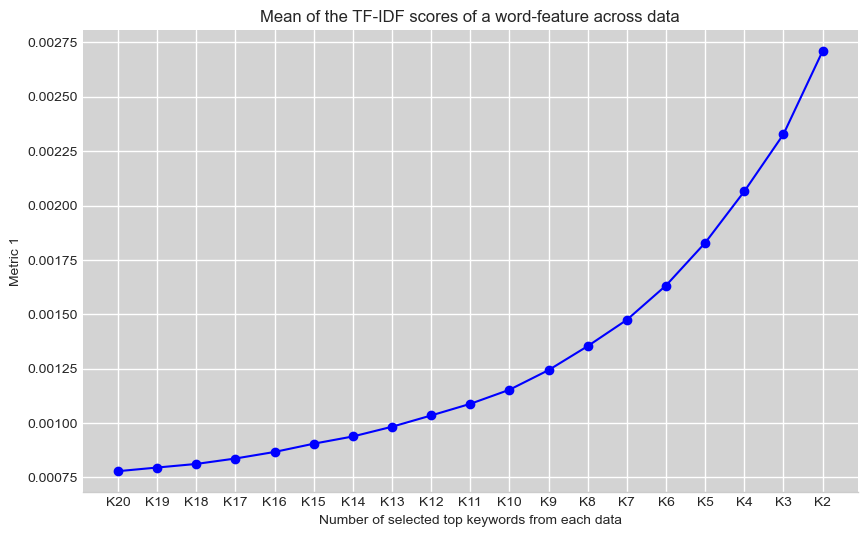

In [27]:
mean_tfidf_scores = []

for count in keyword_counts:
    top_keywords = []

    for doc_idx in range(len(df)):
        tfidf_scores = tfidf_matrix[doc_idx].toarray()[0]
        top_indices = np.argsort(tfidf_scores)[-count:]
        top_keywords.extend([feature_names[idx] for idx in top_indices])
    top_keywords = list(set(top_keywords))

    keyword_indices = [np.where(np.array(feature_names) == keyword)[0][0] for keyword in top_keywords]
    keyword_tfidf_scores = tfidf_matrix[:, keyword_indices].toarray()

    # TF-IDF score 평균 계산
    mean_tfidf_score = np.mean(keyword_tfidf_scores)
    mean_tfidf_scores.append(mean_tfidf_score)

plot_keywords(keyword_counts, mean_tfidf_scores, 'Metric 1',  'Mean of the TF-IDF scores of a word-feature across data')

#### Metric 2 : Mean of the cosine similarities of a word-feature to other features


C:\Users\jjska\AppData\Local\Temp\ipykernel_50572\578327706.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


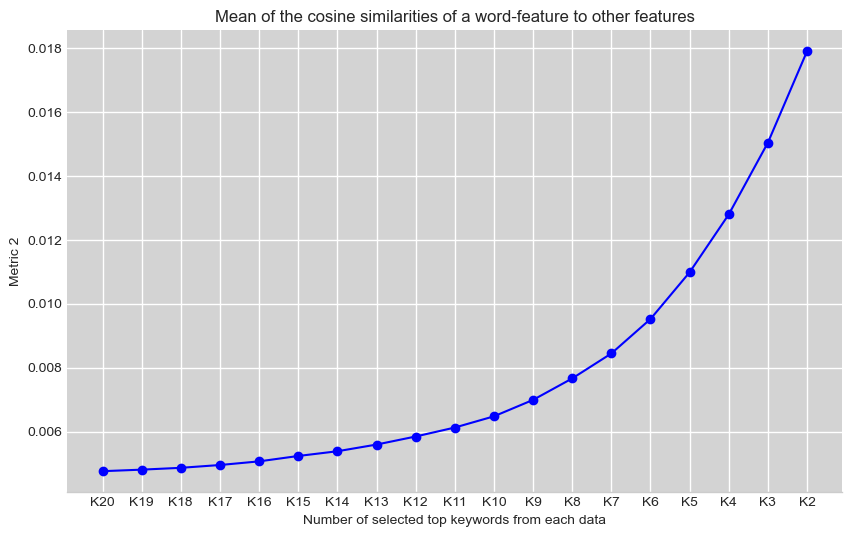

In [28]:
mean_cosine_similarities = []

for num_keywords in keyword_counts:
    top_keywords = []

    for doc_idx in range(len(df)):
        tfidf_scores = tfidf_matrix[doc_idx].toarray()[0]
        top_indices = np.argsort(tfidf_scores)[-num_keywords:]
        top_keywords.extend([feature_names[idx] for idx in top_indices])

    top_keywords = list(set(top_keywords))

    keyword_indices = [np.where(np.array(feature_names) == keyword)[0][0] for keyword in top_keywords]
    keyword_matrix = tfidf_matrix[:, keyword_indices].T
    cosine_similarities = cosine_similarity(keyword_matrix)

    mean_cosine_similarity = np.mean(cosine_similarities)
    mean_cosine_similarities.append(mean_cosine_similarity)

plot_keywords(keyword_counts, mean_cosine_similarities,'Metric 2', 'Mean of the cosine similarities of a word-feature to other features')

#### Metric 3 : Cosine similarity between a word-feature and the centroid of features

C:\Users\jjska\AppData\Local\Temp\ipykernel_50572\578327706.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


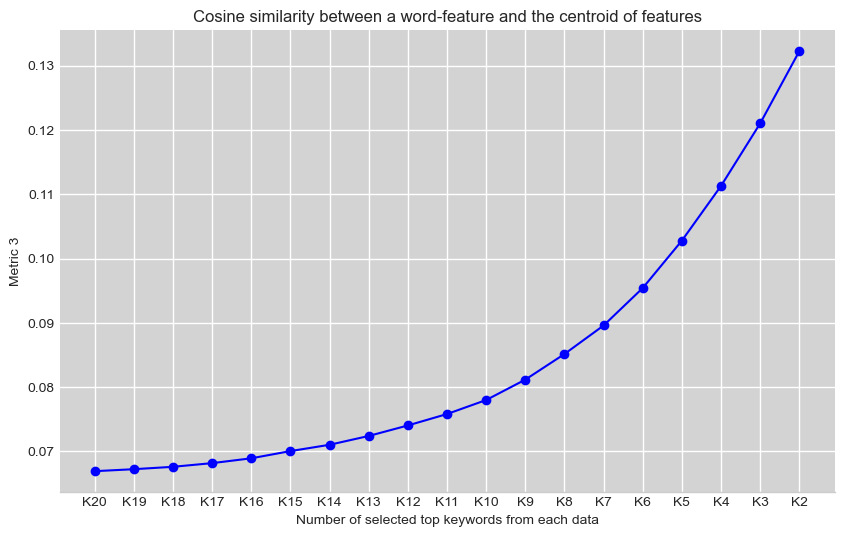

In [29]:
median_cosine_similarities = []

for count in keyword_counts:
    top_keywords = []

    for doc_idx in range(len(df)):
        tfidf_scores = tfidf_matrix[doc_idx].toarray()[0]
        top_indices = np.argsort(tfidf_scores)[-count:]
        top_keywords.extend([feature_names[idx] for idx in top_indices])

    top_keywords = list(set(top_keywords))

    keyword_indices = [np.where(np.array(feature_names) == keyword)[0][0] for keyword in top_keywords]
    keyword_matrix = tfidf_matrix[:, keyword_indices]

    keyword_matrix = keyword_matrix.T.toarray()

    centroid = np.mean(keyword_matrix, axis=0)
    centroid = np.asarray(centroid).reshape(1, -1)

    cosine_similarities = []

    for idx in range(keyword_matrix.shape[0]):
        word_vector = keyword_matrix[idx, :]
        word_vector = np.asarray(word_vector).reshape(1, -1)
        cosine_similarity_value = cosine_similarity(word_vector, centroid)
        cosine_similarities.append(cosine_similarity_value[0][0])


    mean_cosine_similarity = np.mean(cosine_similarities)
    median_cosine_similarities.append(mean_cosine_similarity)

plot_keywords(keyword_counts, median_cosine_similarities, "Metric 3", "Cosine similarity between a word-feature and the centroid of features")

#### Metric 4 : Mean of the dot product scores of a word-feature to other features

C:\Users\jjska\AppData\Local\Temp\ipykernel_50572\578327706.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


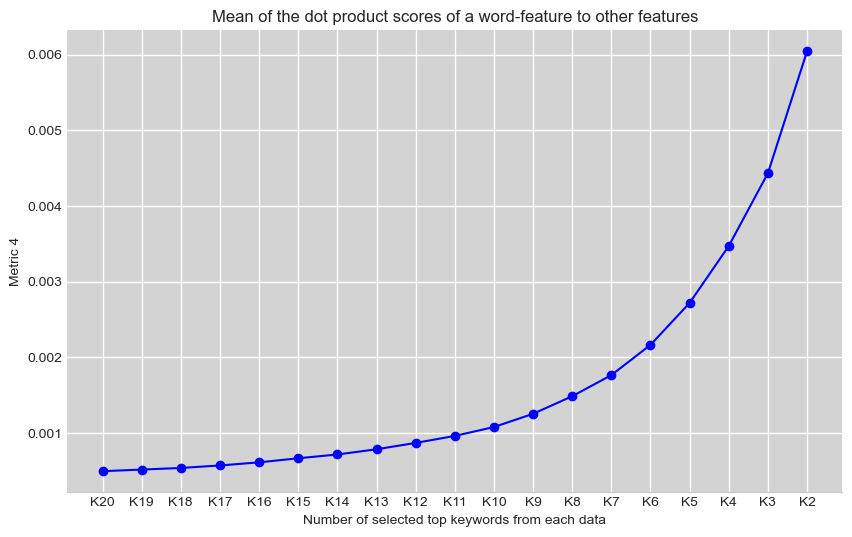

In [30]:
mean_dot_product_scores = []

for count in keyword_counts:
    top_keywords = []

    for doc_idx in range(len(df)):
        tfidf_scores = tfidf_matrix[doc_idx].toarray()[0]
        top_indices = np.argsort(tfidf_scores)[-count:]
        top_keywords.extend([feature_names[idx] for idx in top_indices])

    top_keywords = list(set(top_keywords))

    keyword_indices = [np.where(np.array(feature_names) == keyword)[0][0] for keyword in top_keywords]
    keyword_tfidf_scores = tfidf_matrix[:, keyword_indices].toarray()
    dot_product_scores = np.dot(keyword_tfidf_scores.T, keyword_tfidf_scores)

    mean_dot_product_score = np.mean(dot_product_scores)
    mean_dot_product_scores.append(mean_dot_product_score)

plot_keywords(keyword_counts, mean_dot_product_scores,"Metric 4", "Mean of the dot product scores of a word-feature to other features")

#### Metric 5 : LDA score of a word-feature for the single topic of entire data set

C:\Users\jjska\AppData\Local\Temp\ipykernel_50572\578327706.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


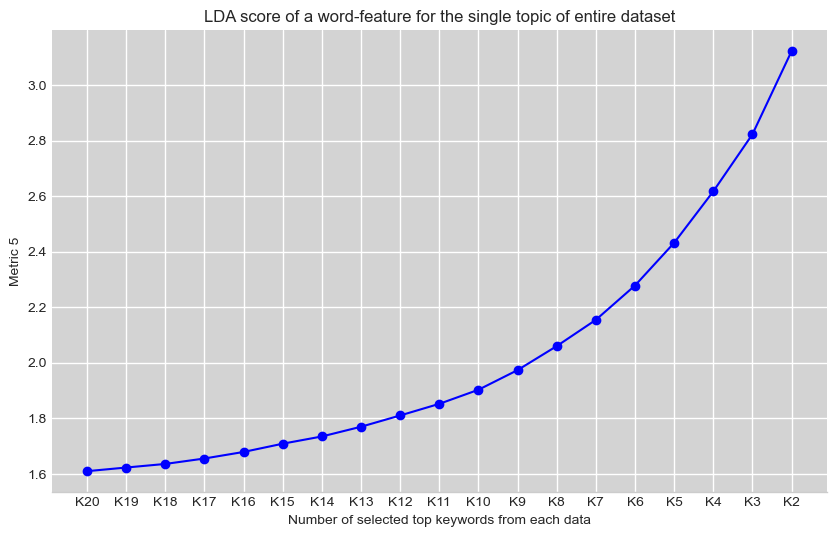

In [31]:
mean_lda_scores = []

for count in keyword_counts:
    top_keywords = []

    for doc_idx in range(len(df)):
        tfidf_scores = tfidf_matrix[doc_idx].toarray()[0]
        top_indices = np.argsort(tfidf_scores)[-count:]
        top_keywords.extend([feature_names[idx] for idx in top_indices])

    top_keywords = list(set(top_keywords))
    keyword_indices = [np.where(np.array(feature_names) == keyword)[0][0] for keyword in top_keywords]
    keyword_matrix = tfidf_matrix[:, keyword_indices].toarray()

    num_topics = 1
    lda_model = LatentDirichletAllocation(n_components=num_topics)
    lda_model.fit(keyword_matrix)

    lda_scores = lda_model.components_

    mean_lda_score = np.mean(lda_scores)
    mean_lda_scores.append(mean_lda_score)

plot_keywords(keyword_counts, mean_lda_scores,"Metric 5", "LDA score of a word-feature for the single topic of entire dataset")

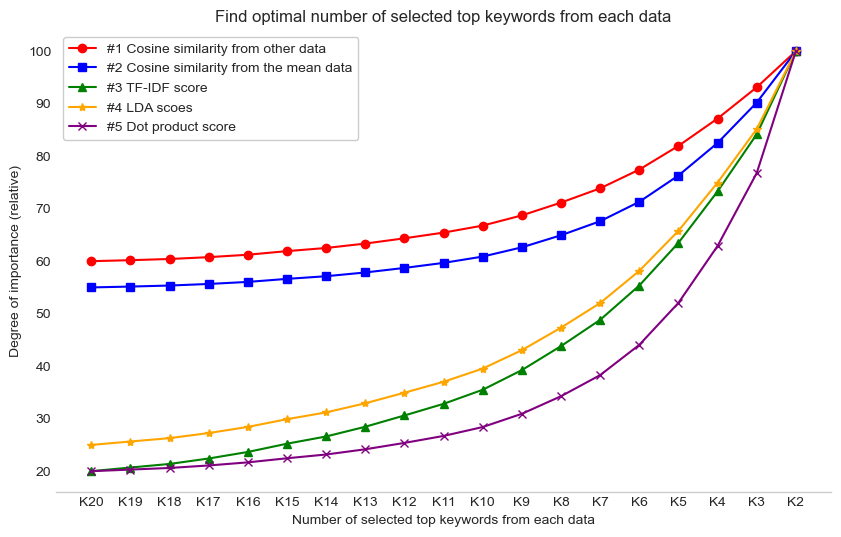

In [35]:
metric1_values = median_cosine_similarities
metric2_values = mean_cosine_similarities
metric3_values = mean_tfidf_scores
metric4_values = mean_lda_scores
metric5_values = mean_dot_product_scores

metric1_normalized = (metric1_values - np.min(metric1_values)) / (np.max(metric1_values) - np.min(metric1_values)) * 40 + 60
metric2_normalized = (metric2_values - np.min(metric2_values)) / (np.max(metric2_values) - np.min(metric2_values)) * 45 + 55
metric3_normalized = (metric3_values - np.min(metric3_values)) / (np.max(metric3_values) - np.min(metric3_values)) * 80 + 20
metric4_normalized = (metric4_values - np.min(metric4_values)) / (np.max(metric4_values) - np.min(metric4_values)) * 75 + 25
metric5_normalized = (metric5_values - np.min(metric5_values)) / (np.max(metric5_values) - np.min(metric5_values)) * 80 + 20

# plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10,6))

plt.gca().invert_xaxis()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.gca().set_facecolor('lightgray')

plt.xticks(range(min(keyword_counts), max(keyword_counts)+1))

k_formatter = FuncFormatter(lambda x, pos: f'K{x}')

plt.gca().xaxis.set_major_formatter(k_formatter)
plt.grid(color='white', linestyle='-', linewidth=1)
plt.xlabel('Number of selected top keywords from each data')
plt.ylabel('Degree of importance (relative)')

plt.plot(keyword_counts, metric1_normalized, marker='o', label='#1 Cosine similarity from other data', color='red')
plt.plot(keyword_counts, metric2_normalized, marker='s', label='#2 Cosine similarity from the mean data', color='blue')
plt.plot(keyword_counts, metric3_normalized, marker='^', label='#3 TF-IDF score', color='green')
plt.plot(keyword_counts, metric4_normalized, marker='*', label='#4 LDA scoes', color='orange')
plt.plot(keyword_counts, metric5_normalized, marker='x', label='#5 Dot product score', color='purple')

plt.xlabel('Number of selected top keywords from each data')
plt.ylabel('Degree of importance (relative)')
plt.title('Find optimal number of selected top keywords from each data')
plt.legend(frameon = True, framealpha=1)

plt.show()

In [36]:
all_keywords = []
top_keywords_per_document = []
feature_names = tfidf_vectorizer.get_feature_names_out()

for i in range(len(df)):
    tfidf_scores = zip(feature_names, tfidf_matrix[i].toarray()[0])
    sorted_tfidf_scores = sorted(tfidf_scores,key=lambda x: x[1], reverse=True)

    top_keywords_per_document.append([keyword for keyword,_ in sorted_tfidf_scores[:5]])

all_keywords=[keyword for document in top_keywords_per_document for keyword in document]

vectorizer = TfidfVectorizer(vocabulary=list(set(all_keywords)))
tfidf_matrix = vectorizer.fit_transform(tsla_df['corpus'])

print("현재 News 갯수:",tfidf_matrix.shape[0])
print("현재 word-feature 갯수:",tfidf_matrix.shape[1])

현재 News 갯수: 783
현재 word-feature 갯수: 1831


#### 설명 : 위의 과정까지가 원본 텍스트 데이터에서 전처리 및 핵심 키워드 추출 등을 거쳐서 벡터화까지 진행한 형태

#### 아래 부터 진행할 내용은 가공된 데이터를 바탕으로 필요한 정보 등을 추출하는 Description analysis

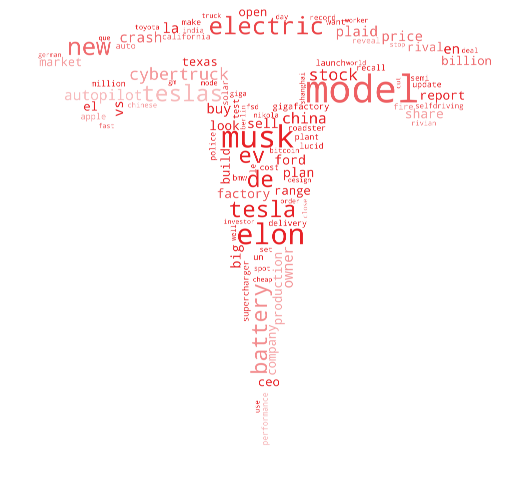

In [51]:
# 워드 클라우드 생성 함수 : Tesla News 들의 Word clound, Tesla logo 모양을 바탕으로 진행, 상위 100개만 표시함

mask = np.array(Image.open("C:/Users/jjska/Desktop/StockPredictionByTextMining/Dataset/tesla_logo.jpg"))

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=list(set(all_keywords)))
average_tfidf = tfidf_df.mean()
average_tfidf_dict = average_tfidf.to_dict()

# 워드 클라우드 생성
image_colors = ImageColorGenerator(mask)

wordcloud = WordCloud(background_color="white",
                      mode="RGBA",
                      mask = mask,
                      width=800, 
                      height=800,
                      scale=2,
                      max_words=100).generate_from_frequencies(average_tfidf_dict)

image_colors = ImageColorGenerator(mask)

plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig("wordcloud.png", dpi=300)
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="antialiased")

In [203]:
# DTM을 데이터프레임으로 변환
temp_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# 각 행별로 TF-IDF 값이 높은 상위 5개의 단어를 선택
top_5_words = temp_df.apply(lambda row: row.nlargest(7).index.tolist(), axis=1)

# 결과를 데이터프레임으로 변환
result_df = pd.DataFrame(top_5_words, columns=['Top_5_Words'])

# 날짜, 키워드 데이터 생성
temp_df = pd.DataFrame({
    'Date': tsla_df['Date'],
    'Keywords' : result_df['Top_5_Words']
})

temp_df.head()

,Date,Keywords
0,2020-01-01,"[allnew, map, rd, israel, office, debut, set]"
1,2020-01-02,"[aqu, coalicin, autovas, complacent, carte, en..."
2,2020-01-03,"[model, bootleg, drd, aralarda, auburn, leave,..."
3,2020-01-06,"[en, model, producir, engine, look, de, un]"
4,2020-01-07,"[sony, ocean, trade, fisker, model, china, stock]"


### 감성 분석

In [204]:
### 감성분석 ###
from collections import defaultdict

# 감성분석 점수 및 키워드를 저장할 딕셔너리 초기화
description_sentiment_scores = defaultdict(float)
keywords_sentiment_scores = defaultdict(float)
keywords_dict = defaultdict(list)

# 감성 단어 개수를 저장할 딕셔너리 초기화
description_uncertainty_count = defaultdict(int)
description_litigious_count = defaultdict(int)
description_constraining_count = defaultdict(int)
description_superfluous_count = defaultdict(int)
description_weakmodal_count = defaultdict(int)
description_positive_count = defaultdict(int)
description_negative_count = defaultdict(int)

keywords_uncertainty_count = defaultdict(int)
keywords_litigious_count = defaultdict(int)
keywords_constraining_count = defaultdict(int)
keywords_superfluous_count = defaultdict(int)
keywords_weakmodal_count = defaultdict(int)
keywords_positive_count = defaultdict(int)
keywords_negative_count = defaultdict(int)

# Loughran-McDonald 사전 로드
sentiment_df = pd.read_csv('C:/Users/jjska/Desktop/StockPredictionByTextMining/Dataset/LM-SA-2020.csv')

# 감성별 사전 초기화
uncertainty_dict = defaultdict(int)
litigious_dict = defaultdict(int)
constraining_dict = defaultdict(int)
superfluous_dict = defaultdict(int)
weakmodal_dict = defaultdict(int)
positive_dict = defaultdict(int)
negative_dict = defaultdict(int)

for _, row in sentiment_df.iterrows():
    word, sentiment = row['word'], row['sentiment']
    if sentiment == 'Uncertainty':
        uncertainty_dict[word] = 1
    elif sentiment == 'Litigious':
        litigious_dict[word] = 1
    elif sentiment == 'Constraining':
        constraining_dict[word] = 1
    elif sentiment == 'Superfluous':
        superfluous_dict[word] = 1
    elif sentiment == 'WeakModal':
        weakmodal_dict[word] = 1
    elif sentiment == 'Positive':
        positive_dict[word] = 1
    elif sentiment == 'Negative':
        negative_dict[word] = -1

In [205]:
all_data = tsla_df.copy()
all_data['Keywords'] = temp_df['Keywords']
all_data.head()

,Date,Publisher,Description,News_Count,corpus,Keywords
0,2020-01-01,"[Electrek, CarBuzz, Globes]",Tesla Cybertruck Makes Music Video Debut AllNe...,4,cybertruck make music debut allnew model look ...,"[allnew, map, rd, israel, office, debut, set]"
1,2020-01-02,"[Investopedia, Reuters, Digital, Trefis, Netta...",Tesla may have been on Autopilot in California...,21,autopilot california crash kill stop cybertruc...,"[aqu, coalicin, autovas, complacent, carte, en..."
2,2020-01-03,"[Dexerto, España, Huddle, CNN, Finance, Forbes...",Tesla to provide movies online games in its ca...,27,provide movie online game car unique bootleg c...,"[model, bootleg, drd, aralarda, auburn, leave,..."
3,2020-01-06,"[–, España, Inceptive, AutoWeek, GTspirit, fDr...",I70 crash one of 3 raising questions about Tes...,45,crash raise question tesla autopilot tesla cyb...,"[en, model, producir, engine, look, de, un]"
4,2020-01-07,"[BNR, DER, QN, Insider, Finance, Fortune, Xinh...",China could be the swing factor for Teslas sto...,27,china swing factor tesla stock model car roll ...,"[sony, ocean, trade, fisker, model, china, stock]"


In [206]:
# 감성 분석 함수
def sentiment_analysis(sentence, sentiment_dict):
    return sum(sentiment_dict[word] for word in sentence.split() if word in sentiment_dict)

# 감성 단어 개수를 세는 함수
def count_sentiment_words(sentences, sentiment_dict, count = 0):
    count += sum(1 for word in sentences.split() if word in sentiment_dict)
    
    return count

pd.DataFrame.iteritems = pd.DataFrame.items

for i, row in all_data.iterrows():
    date = row['Date']
    descriptions  = row['corpus']
    
    keywords = row['Keywords']
    keywords = " ".join(keywords)

    # 감성분석 점수 계산 (키워드의 감성 점수 합)
    keywords_sentiment_scores[date] = sum(sentiment_analysis(str(keywords), sentiment) 
                                          for sentiment in [positive_dict, negative_dict])

    # 감성분석 점수 계산 (감성 점수 합)
    description_sentiment_scores[date] = round(sum(sentiment_analysis(descriptions, sentiment) 
                                                   for sentiment in [positive_dict, negative_dict])/row['News_Count'], 4)
    
    keywords_uncertainty_count[date] = count_sentiment_words(str(keywords), uncertainty_dict)
    keywords_litigious_count[date] = count_sentiment_words(str(keywords), litigious_dict)
    keywords_constraining_count[date] = count_sentiment_words(str(keywords), constraining_dict)
    keywords_superfluous_count[date] = count_sentiment_words(str(keywords), superfluous_dict)
    keywords_weakmodal_count[date] = count_sentiment_words(str(keywords), weakmodal_dict)
    keywords_positive_count[date] = count_sentiment_words(str(keywords), positive_dict)
    keywords_negative_count[date] = count_sentiment_words(str(keywords), negative_dict)

    description_uncertainty_count[date] = count_sentiment_words(descriptions, uncertainty_dict)
    description_litigious_count[date] = count_sentiment_words(descriptions, litigious_dict)
    description_constraining_count[date] = count_sentiment_words(descriptions, constraining_dict)
    description_superfluous_count[date] = count_sentiment_words(descriptions, superfluous_dict)
    description_weakmodal_count[date] = count_sentiment_words(descriptions, weakmodal_dict)
    description_positive_count[date] = count_sentiment_words(descriptions, positive_dict)
    description_negative_count[date] = count_sentiment_words(descriptions, negative_dict)

# 감성분석 점수와 키워드를 데이터프레임에 추가
all_data['Description_Sentiment_Score'] = all_data['Date'].map(description_sentiment_scores)
all_data['Keywords_Sentiment_Score'] = all_data['Date'].map(keywords_sentiment_scores)

all_data['Keywords_Uncertainty_Count'] = all_data['Date'].map(keywords_uncertainty_count)
all_data['Keywords_Litigious_Count'] = all_data['Date'].map(keywords_litigious_count)
all_data['Keywords_Constraining_Count'] = all_data['Date'].map(keywords_constraining_count)
all_data['Keywords_Superfluous_Count'] = all_data['Date'].map(keywords_superfluous_count)
all_data['Keywords_WeakModal_Count'] = all_data['Date'].map(keywords_weakmodal_count)
all_data['Keywords_Positive_Count'] = all_data['Date'].map(keywords_positive_count)
all_data['Keywords_Negative_Count'] = all_data['Date'].map(keywords_negative_count)

all_data['Description_Uncertainty_Count'] = all_data['Date'].map(description_uncertainty_count)
all_data['Description_Litigious_Count'] = all_data['Date'].map(description_litigious_count)
all_data['Description_Constraining_Count'] = all_data['Date'].map(description_constraining_count)
all_data['Description_Superfluous_Count'] = all_data['Date'].map(description_superfluous_count)
all_data['Description_WeakModal_Count'] = all_data['Date'].map(description_weakmodal_count)
all_data['Description_Positive_Count'] = all_data['Date'].map(description_positive_count)
all_data['Description_Negative_Count'] = all_data['Date'].map(description_negative_count)

all_data.head()

,Date,Publisher,Description,News_Count,corpus,Keywords,Description_Sentiment_Score,Keywords_Sentiment_Score,Keywords_Uncertainty_Count,Keywords_Litigious_Count,...,Keywords_WeakModal_Count,Keywords_Positive_Count,Keywords_Negative_Count,Description_Uncertainty_Count,Description_Litigious_Count,Description_Constraining_Count,Description_Superfluous_Count,Description_WeakModal_Count,Description_Positive_Count,Description_Negative_Count
0,2020-01-01,"[Electrek, CarBuzz, Globes]",Tesla Cybertruck Makes Music Video Debut AllNe...,4,cybertruck make music debut allnew model look ...,"[allnew, map, rd, israel, office, debut, set]",0.2500,0,0,0,...,0,0,0,1,0,0,0,0,2,1
1,2020-01-02,"[Investopedia, Reuters, Digital, Trefis, Netta...",Tesla may have been on Autopilot in California...,21,autopilot california crash kill stop cybertruc...,"[aqu, coalicin, autovas, complacent, carte, en...",-0.2381,0,0,0,...,0,0,0,1,0,1,0,0,12,17
2,2020-01-03,"[Dexerto, España, Huddle, CNN, Finance, Forbes...",Tesla to provide movies online games in its ca...,27,provide movie online game car unique bootleg c...,"[model, bootleg, drd, aralarda, auburn, leave,...",-0.3333,0,0,1,...,0,2,2,5,4,0,0,0,19,28
3,2020-01-06,"[–, España, Inceptive, AutoWeek, GTspirit, fDr...",I70 crash one of 3 raising questions about Tes...,45,crash raise question tesla autopilot tesla cyb...,"[en, model, producir, engine, look, de, un]",-0.3556,0,1,0,...,0,1,1,10,13,1,0,0,32,48
4,2020-01-07,"[BNR, DER, QN, Insider, Finance, Fortune, Xinh...",China could be the swing factor for Teslas sto...,27,china swing factor tesla stock model car roll ...,"[sony, ocean, trade, fisker, model, china, stock]",-0.1111,0,0,0,...,0,1,1,3,1,0,0,0,13,16


In [207]:
all_data.describe()

,News_Count,Description_Sentiment_Score,Keywords_Sentiment_Score,Keywords_Uncertainty_Count,Keywords_Litigious_Count,Keywords_Constraining_Count,Keywords_Superfluous_Count,Keywords_WeakModal_Count,Keywords_Positive_Count,Keywords_Negative_Count,Description_Uncertainty_Count,Description_Litigious_Count,Description_Constraining_Count,Description_Superfluous_Count,Description_WeakModal_Count,Description_Positive_Count,Description_Negative_Count
count,783.000000,783.000000,783.000000,783.000000,783.000000,783.000000,783.0,783.0,783.000000,783.000000,783.000000,783.000000,783.000000,783.0,783.000000,783.000000,783.000000
mean,22.680715,-0.440527,-0.541507,0.107280,0.233716,0.104725,0.0,0.0,0.644955,1.186462,3.920817,5.298851,2.575990,0.0,0.162197,12.957854,23.026820
std,9.192748,0.260059,1.001534,0.321817,0.495801,0.314632,0.0,0.0,0.733992,1.036900,2.604612,3.370185,2.135807,0.0,0.423723,6.534544,11.024991
min,4.000000,-1.411800,-4.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000
25%,17.000000,-0.605550,-1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,2.000000,3.000000,1.000000,0.0,0.000000,8.000000,15.000000
50%,20.000000,-0.433300,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,1.000000,4.000000,5.000000,2.000000,0.0,0.000000,12.000000,21.000000
75%,27.000000,-0.262050,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,2.000000,5.000000,7.000000,4.000000,0.0,0.000000,16.000000,28.000000
max,59.000000,0.428600,3.000000,2.000000,3.000000,2.000000,0.0,0.0,3.000000,5.000000,15.000000,26.000000,14.000000,0.0,2.000000,50.000000,70.000000


In [175]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 설치된 폰트 중 원하는 한글 폰트의 전체 경로 가져오기
font_path = fm.findfont(fm.FontProperties(fname='NanumGothic'))

# matplotlib의 rc(run command) 명령을 사용해 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'

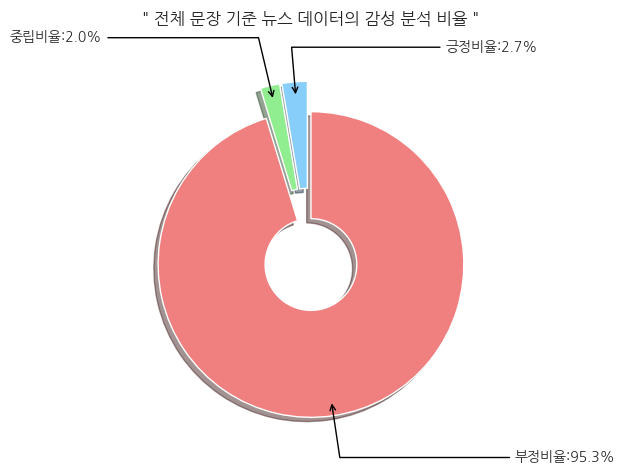

In [252]:
### Description 기준 감성 점수의 비율 ###

# 감성 점수가 0 이상의 경우 긍정
pos = len(all_data[all_data['Description_Sentiment_Score'] > 0])/len(all_data)
# 감성 점수가 0 인 경우 중립
nue = len(all_data[all_data['Description_Sentiment_Score'] == 0])/len(all_data)
# 감성 점수가 0 이하의 경우 부정
neg = len(all_data[all_data['Description_Sentiment_Score'] < 0])/len(all_data)

wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 1}
explode = [0.1, 0.1, 0.1]

# 긍정부정중립 비율 그래프
colors = [ 'lightskyblue','lightgreen','lightcoral']
labels = ['긍정', '중립', '부정']
sizes = [pos, nue, neg]

fig, ax = plt.subplots()
wedges, texts = ax.pie(sizes, colors=colors, startangle=90, explode=explode, shadow=True, wedgeprops=wedgeprops)

ax.axis('equal')

# 각 부분을 가리키는 화살표와 비율 레이블 추가
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    if labels[i] == '긍정':
        xytext = (1.5, 1.3)
    else:
        xytext = (1.35*np.sign(x), 1.4*y)
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    labeling = str(labels[i])+"비율:"
    ax.annotate(labeling+'{:.1f}%'.format(sizes[i]*100),
                xy=(x, y), xytext=xytext,
                horizontalalignment=horizontalalignment,
                arrowprops=dict(arrowstyle="->", connectionstyle=connectionstyle))

plt.title('" 전체 문장 기준 뉴스 데이터의 감성 분석 비율 "', weight='bold', pad=30)

plt.show()

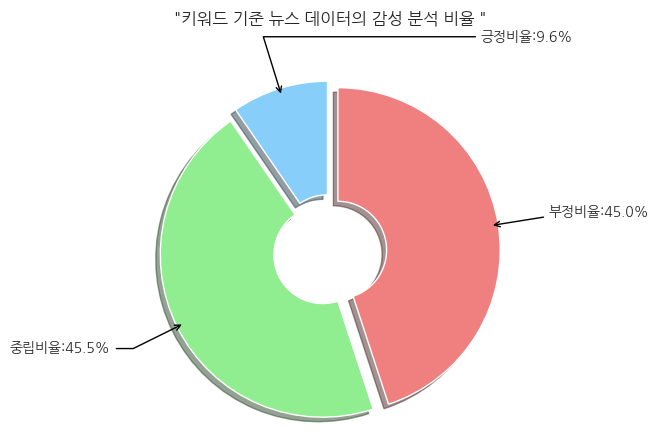

In [251]:
### Keywords 기준 감성 점수의 비율 ###

# 감성 점수가 0 이상의 경우 긍정
key_pos = len(all_data[all_data['Keywords_Sentiment_Score'] > 0])/len(all_data)
# 감성 점수가 0 인 경우 중립
key_nue = len(all_data[all_data['Keywords_Sentiment_Score'] == 0])/len(all_data)
# 감성 점수가 0 이하의 경우 부정
key_neg = len(all_data[all_data['Keywords_Sentiment_Score'] < 0])/len(all_data)

wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 1}
explode = [0.05, 0.05, 0.05]

# 긍정부정중립 비율 그래프
colors = [ 'lightskyblue','lightgreen','lightcoral']
labels = ['긍정', '중립', '부정']
sizes = [key_pos, key_nue, key_neg]

fig, ax = plt.subplots()
wedges, texts = ax.pie(sizes, colors=colors, startangle=90, explode=explode, shadow=True, wedgeprops=wedgeprops)

ax.axis('equal')

# 각 부분을 가리키는 화살표와 비율 레이블 추가
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    if labels[i] == '긍정':
        xytext = (1.5, 1.3)
    else:
        xytext = (1.35*np.sign(x), 1.4*y)
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    labeling = str(labels[i])+"비율:"
    ax.annotate(labeling+'{:.1f}%'.format(sizes[i]*100),
                xy=(x, y), xytext=xytext,
                horizontalalignment=horizontalalignment,
                arrowprops=dict(arrowstyle="->", connectionstyle=connectionstyle))

plt.title('"키워드 기준 뉴스 데이터의 감성 분석 비율 "', weight='bold', pad=30)

plt.show()

#### 새로운 감성 분석 사전 시도

#### https://github.com/yya518/FinBERT 감성 모델 추출 : PPT 만들 때 해당 링크 설명 참조해서 첨부 바람

In [177]:
dataset = all_data['Keywords'].tolist()

In [103]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

import transformers
transformers.__version__

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

C:\Users\jjska\anaconda3\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jjska\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [160]:
nlp = pipeline("text-classification", model=finbert, tokenizer=tokenizer)
result = []

for check in dataset:
    result.append(nlp([" ".join(check)]))

In [255]:
all_data['result'] = result

all_data['label'] = all_data['result'].apply(lambda x: x[0]['label'])
all_data['score'] = all_data['result'].apply(lambda x: x[0]['score'])

all_data.drop(columns=['result'], inplace = True)
all_data.head()

,Date,Publisher,Description,News_Count,corpus,Keywords,Description_Sentiment_Score,Keywords_Sentiment_Score,Keywords_Uncertainty_Count,Keywords_Litigious_Count,...,Keywords_Negative_Count,Description_Uncertainty_Count,Description_Litigious_Count,Description_Constraining_Count,Description_Superfluous_Count,Description_WeakModal_Count,Description_Positive_Count,Description_Negative_Count,label,score
0,2020-01-01,"[Electrek, CarBuzz, Globes]",Tesla Cybertruck Makes Music Video Debut AllNe...,4,cybertruck make music debut allnew model look ...,"[allnew, map, rd, israel, office, debut, set]",0.2500,0,0,0,...,0,1,0,0,0,0,2,1,Neutral,0.999996
1,2020-01-02,"[Investopedia, Reuters, Digital, Trefis, Netta...",Tesla may have been on Autopilot in California...,21,autopilot california crash kill stop cybertruc...,"[aqu, coalicin, autovas, complacent, carte, en...",-0.2381,0,0,0,...,0,1,0,1,0,0,12,17,Neutral,0.999896
2,2020-01-03,"[Dexerto, España, Huddle, CNN, Finance, Forbes...",Tesla to provide movies online games in its ca...,27,provide movie online game car unique bootleg c...,"[model, bootleg, drd, aralarda, auburn, leave,...",-0.3333,0,0,1,...,2,5,4,0,0,0,19,28,Neutral,0.698553
3,2020-01-06,"[–, España, Inceptive, AutoWeek, GTspirit, fDr...",I70 crash one of 3 raising questions about Tes...,45,crash raise question tesla autopilot tesla cyb...,"[en, model, producir, engine, look, de, un]",-0.3556,0,1,0,...,1,10,13,1,0,0,32,48,Neutral,0.999975
4,2020-01-07,"[BNR, DER, QN, Insider, Finance, Fortune, Xinh...",China could be the swing factor for Teslas sto...,27,china swing factor tesla stock model car roll ...,"[sony, ocean, trade, fisker, model, china, stock]",-0.1111,0,0,0,...,1,3,1,0,0,0,13,16,Neutral,0.999995


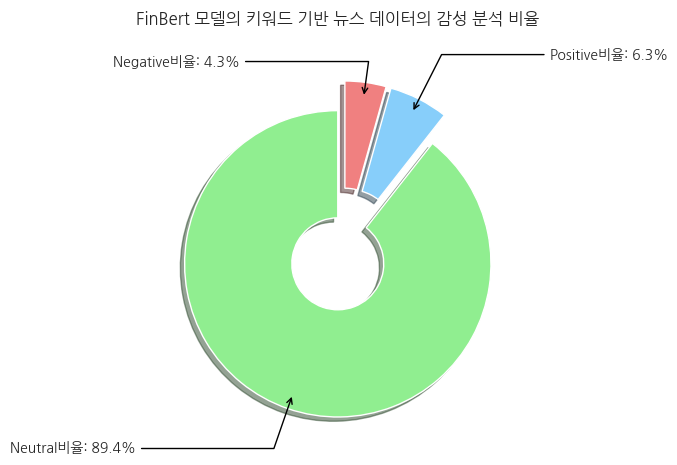

In [265]:
# 'label' 값별 비율 계산
label_counts = all_data['label'].value_counts()

color_dict = {'Negative': 'lightcoral', 'Positive': 'lightskyblue', 'Neutral': 'lightgreen'}
colors = [color_dict[label] for label in label_counts.index]

wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 1}
explode = [0.1, 0.1, 0.1]

# 파이 차트 그리기
fig, ax = plt.subplots()
wedges, texts = ax.pie(label_counts, colors=colors, startangle=90, 
                       explode=explode, shadow=True, wedgeprops=wedgeprops)

ax.axis('equal')

# 각 부분을 가리키는 화살표와 비율 레이블 추가
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    if label_counts.index[i] == 'Negative':
        xytext = (-1.5, 1.2)
    else:
        xytext = (1.35*np.sign(x), 1.4*y)
    labeling = str(label_counts.index[i])+"비율: "
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    ax.annotate(labeling +'{:.1f}%'.format(label_counts[i]/label_counts.sum()*100),
                xy=(x, y), xytext=xytext,
                horizontalalignment=horizontalalignment,
                arrowprops=dict(arrowstyle="->", connectionstyle=connectionstyle))

# 차트 제목 설정 및 간격 조정
plt.title('FinBert 모델의 키워드 기반 뉴스 데이터의 감성 분석 비율', weight='bold', pad=30)

plt.show()

In [268]:
all_data.columns

Index(['Date', 'Publisher', 'Description', 'News_Count', 'corpus', 'Keywords',
       'Description_Sentiment_Score', 'Keywords_Sentiment_Score',
       'Keywords_Uncertainty_Count', 'Keywords_Litigious_Count',
       'Keywords_Constraining_Count', 'Keywords_Superfluous_Count',
       'Keywords_WeakModal_Count', 'Keywords_Positive_Count',
       'Keywords_Negative_Count', 'Description_Uncertainty_Count',
       'Description_Litigious_Count', 'Description_Constraining_Count',
       'Description_Superfluous_Count', 'Description_WeakModal_Count',
       'Description_Positive_Count', 'Description_Negative_Count', 'label',
       'score'],
      dtype='object')

In [272]:
columns  = ['Date', 'Publisher', 'Description', 'News_Count', 'corpus', 'Keywords', 'Description_Sentiment_Score',
            'Keywords_Sentiment_Score', 'Keywords_Positive_Count', 'Keywords_Negative_Count', 'Description_Positive_Count', 
            'Description_Negative_Count', 'label', 'score']

# 주어진 열만 포함하는 새 DataFrame 생성
filtered_data = all_data[columns]

# 'Date' 열을 인덱스로 설정
filtered_data.set_index('Date', inplace=True)
filtered_data.head()

filtered_data.to_csv('C:/Users/jjska/Desktop/StockPredictionByTextMining/Dataset/Output/text_analysis_completed_data.csv')